In [1]:
from keras import layers
from keras import Input
from keras.models import Model, load_model
from keras.optimizers import rmsprop, adam

Using TensorFlow backend.


In [21]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.externals import joblib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

In [4]:
h5f = h5py.File('D:/total_data_ro.h5','r')
test_data = h5f['total_2019'][:]
test_data_gen = h5f['gen_2019'][:]
h5f.close()

In [5]:
sc = RobustScaler()
sc = joblib.load('./data/scaler_gen.pkl')
test_data_gen = test_data_gen.reshape(-1, 1)

In [6]:
test_data_gen.shape

(4344, 1)

In [7]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), delay))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = target[rows[j] - 1: rows[j] + delay - 1][:,0]
        #yield samples, targets
        return samples, [targets[:,0], targets[:,1], targets[:,2], targets[:,3], targets[:,4], targets[:,5], targets[:,6], targets[:,7], targets[:,8], targets[:,9], targets[:,10], targets[:,11], targets[:,12], targets[:,13], targets[:,14], targets[:,15], targets[:,16], targets[:,17], targets[:,18], targets[:,19], targets[:,20], targets[:,21], targets[:,22], targets[:,23], targets[:,24], targets[:,25], targets[:,26], targets[:,27], targets[:,28], targets[:,29], targets[:,30], targets[:,31], targets[:,32], targets[:,33], targets[:,34], targets[:,35], targets[:,36], targets[:,37], targets[:,38], targets[:,39], targets[:,40], targets[:,41], targets[:,42], targets[:,43], targets[:,44], targets[:,45], targets[:,46], targets[:,47], targets[:,48], targets[:,49], targets[:,50], targets[:,51], targets[:,52], targets[:,53], targets[:,54], targets[:,55], targets[:,56], targets[:,57], targets[:,58], targets[:,59], targets[:,60], targets[:,61], targets[:,62], targets[:,63], targets[:,64], targets[:,65], targets[:,66], targets[:,67], targets[:,68], targets[:,69], targets[:,70], targets[:,71]]

In [8]:
img_input = Input(shape=(None, 75, 75, 10), name='images')
convlstm2d = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', return_sequences=True,
                   padding='same')(img_input)
batch_norm = layers.BatchNormalization()(convlstm2d)

convlstm2d_1x1 = layers.ConvLSTM2D(filters=1, kernel_size=(3, 3),
                    data_format='channels_last',padding='same')(batch_norm)
batch_norm = layers.BatchNormalization()(convlstm2d_1x1)

flatten = layers.Flatten()(batch_norm)

Dense_1_list = [layers.Dense(units=1)(flatten) for i in range(72)]

model = Model(img_input, Dense_1_list)

model.compile(optimizer=rmsprop(lr=0.001), loss=['mae' for i in range(72)])
model.load_weights('./data/gen_pred_72hours.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
test_sample, gen_sample = generator(test_data, test_data_gen, 120, 72, 0, None, shuffle=True, batch_size=1)
test_sample = np.rollaxis(test_sample, 2, 5)

In [10]:
y_pred = model.predict(test_sample)
y_pred = np.array(y_pred).reshape(-1,1)
y_test = np.array(gen_sample)

In [11]:
y_pred.shape, y_test.shape

((72, 1), (72, 1))

In [12]:
y_test.min(), y_test.max()

(0.0, 0.6264)

In [13]:
y_pred.min(), y_pred.max()

(-0.1378411, 0.13396916)

In [14]:
y_pred = sc.inverse_transform(y_pred)

In [15]:
y_test.shape, y_pred.shape

((72, 1), (72, 1))

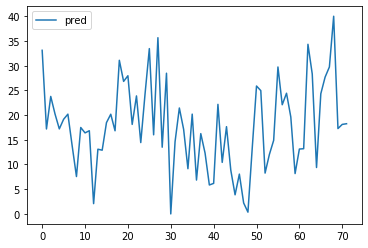

In [27]:
sc = MinMaxScaler(feature_range=(0, 40))
plt.plot(sc.fit_transform(y_pred), label='pred')
#plt.plot(gen_sample, label='real')
plt.legend()
plt.savefig("test.png")
plt.show()